<a href="https://colab.research.google.com/github/Sawan866/ForestFirePredictionModis/blob/main/Prediction_LSTM1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd


In [ ]:
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project/test_data.csv')

In [ ]:
train  = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project/train_data.csv')

In [ ]:
valid = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project/valid_data.csv')

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303419 entries, 0 to 303418
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   latitude     303419 non-null  float64
 1   longitude    303419 non-null  float64
 2   brightness   303419 non-null  float64
 3   scan         303419 non-null  float64
 4   acq_date     303419 non-null  object 
 5   acq_time     303419 non-null  int64  
 6   satellite_0  303419 non-null  int64  
 7   instrument   303419 non-null  object 
 8   confidence   303419 non-null  int64  
 9   version      303419 non-null  float64
 10  bright_t31   303419 non-null  float64
 11  frp          303419 non-null  float64
 12  type         303419 non-null  int64  
dtypes: float64(7), int64(4), object(2)
memory usage: 30.1+ MB


In [ ]:
def group_and_arrange(df, groupby_cols):
    df_grouped = df.groupby(groupby_cols).size().reset_index()
    df_grouped.columns = list(groupby_cols) + ['frequency']
    return df_grouped.drop(columns='frequency')

In [ ]:
df_test = group_and_arrange(test, ['brightness', 'scan', 'confidence', 'bright_t31', 'frp', 'type'])

In [ ]:
df_test

,brightness,scan,confidence,bright_t31,frp,type
0,300.0,1.0,2,284.4,2.3,0
1,300.0,1.0,5,279.2,3.3,0
2,300.0,1.0,5,280.7,2.8,0
3,300.0,1.0,7,289.7,4.9,2
4,300.0,1.0,9,288.1,3.9,0
...,...,...,...,...,...,...
303255,502.2,1.1,100,400.1,1835.7,0
303256,502.7,1.1,100,400.1,1811.8,0
303257,503.0,1.1,100,400.1,1808.2,0
303258,503.1,2.1,100,329.2,4966.9,0


In [ ]:
df_train = group_and_arrange(train, ['brightness', 'scan', 'confidence', 'bright_t31', 'frp', 'type'])
df_train

,brightness,scan,confidence,bright_t31,frp,type
0,300.0,1.0,1,289.0,3.5,0
1,300.0,1.0,2,285.5,5.2,2
2,300.0,1.0,2,286.4,5.0,0
3,300.0,1.0,2,287.8,5.1,0
4,300.0,1.0,2,288.9,8.5,0
...,...,...,...,...,...,...
1210813,505.3,1.0,100,400.1,1759.3,0
1210814,505.7,1.1,100,400.1,1924.3,0
1210815,505.8,1.1,94,400.1,2071.9,0
1210816,506.1,1.0,100,336.8,1774.4,0


In [ ]:
df_valid = group_and_arrange(valid, ['brightness', 'scan', 'confidence', 'bright_t31', 'frp', 'type'])
df_valid

,brightness,scan,confidence,bright_t31,frp,type
0,300.0,1.0,1,289.0,3.5,0
1,300.0,1.0,2,284.4,2.3,0
2,300.0,1.0,2,285.5,5.2,2
3,300.0,1.0,2,286.4,5.0,0
4,300.0,1.0,2,287.8,5.1,0
...,...,...,...,...,...,...
1512716,505.3,1.0,100,400.1,1759.3,0
1512717,505.7,1.1,100,400.1,1924.3,0
1512718,505.8,1.1,94,400.1,2071.9,0
1512719,506.1,1.0,100,336.8,1774.4,0


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
features = ['brightness', 'scan', 'confidence', 'bright_t31', 'frp']
target = ['type']

In [ ]:
# Define the LSTM model
model = keras.Sequential()
model.add(layers.LSTM(64, input_shape=(1, len(features)), activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy', keras.metrics.Precision(),
                       keras.metrics.Recall(),
                       keras.metrics.RootMeanSquaredError(),
                       keras.metrics.AUC()])

In [ ]:
# Define early stopping callback
early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                        patience=5,
                                                        mode='max',
                                                        verbose=1)

In [ ]:
# Define a callback to save checkpoints
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='best_model_weights.h5',
    save_weights_only=True,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

In [ ]:
# Train the model
history = model.fit(np.array(df_train[features]).reshape(-1, 1, len(features)), np.array(df_train[target]),
                    validation_data=(np.array(df_valid[features]).reshape(-1, 1, len(features)), np.array(df_valid[target])),
                    epochs=10,
                    batch_size=32,
                    verbose=1,
                    callbacks=[early_stopping_callback, checkpoint_callback])

Epoch 1/10
37838/37839 [============================>.] - ETA: 0s - loss: 0.2283 - accuracy: 0.9658 - precision: 0.2742 - recall: 0.0067 - root_mean_squared_error: 0.3589 - auc: 0.7028
Epoch 1: val_accuracy improved from -inf to 0.96630, saving model to best_model_weights.h5
37839/37839 [==============================] - 445s 12ms/step - loss: 0.2283 - accuracy: 0.9658 - precision: 0.2742 - recall: 0.0067 - root_mean_squared_error: 0.3589 - auc: 0.7028 - val_loss: 0.2224 - val_accuracy: 0.9663 - val_precision: 0.7955 - val_recall: 0.0034 - val_root_mean_squared_error: 0.3579 - val_auc: 0.7472
Epoch 2/10
37838/37839 [============================>.] - ETA: 0s - loss: 0.2196 - accuracy: 0.9652 - precision: 0.2526 - recall: 0.0114 - root_mean_squared_error: 0.3579 - auc: 0.7258
Epoch 2: val_accuracy did not improve from 0.96630
37839/37839 [==============================] - 437s 12ms/step - loss: 0.2196 - accuracy: 0.9652 - precision: 0.2526 - recall: 0.0114 - root_mean_squared_error: 0.35

In [ ]:
# Predict on test set
test_predictions = model.predict(np.array(test[features]).reshape(-1, 1, len(features)))

9482/9482 [==============================] - 19s 2ms/step


In [ ]:
# Calculate metrics
test_acc = metrics.accuracy_score(test[target], np.round(test_predictions))
test_f1 = metrics.f1_score(test[target], np.round(test_predictions), average = 'weighted' )
test_precision = metrics.precision_score(test[target], np.round(test_predictions), average = 'weighted')
test_recall = metrics.recall_score(test[target], np.round(test_predictions), average = 'weighted')
test_rmse = np.sqrt(metrics.mean_squared_error(test[target], test_predictions))
# test_auc = metrics.roc_auc_score(test[target], test_predictions, multi_class = 'ovr')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Print the metrics
print("Test Accuracy: ", test_acc)
print("Test F1 Score: ", test_f1)
print("Test Precision: ", test_precision)
print("Test Recall: ", test_recall)
print("Test Root Mean Squared Error: ", test_rmse)

Test Accuracy:  0.966215035973357
Test F1 Score:  0.9498596049077022
Test Precision:  0.9340516482092144
Test Recall:  0.966215035973357
Test Root Mean Squared Error:  0.356284409723072


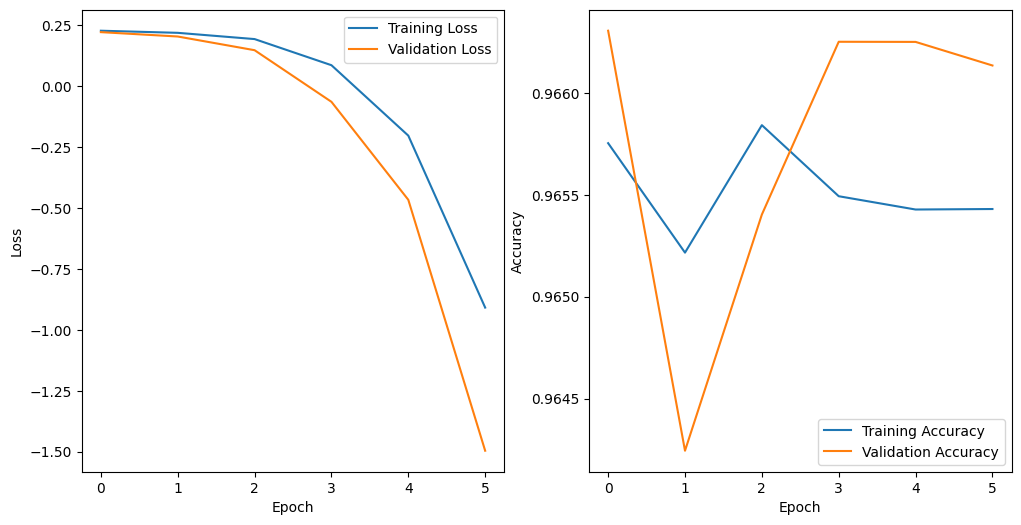

In [ ]:
%matplotlib inline
# Plot the loss and accuracy over the epochs
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()